# Quantum Phase Estimation (QPE) for H₂ — **Noisy**

- Uses PennyLane and project utilities
- Adds simple depolarizing noise model
- Compares to Hartree–Fock (HF)
- Includes sweeps over noise strengths

In [1]:
import numpy as np

from qpe.core import run_qpe
from qpe.hamiltonian import build_hamiltonian
from qpe.io_utils import ensure_dirs, signature_hash, load_qpe_result, save_qpe_result
from qpe.visualize import plot_qpe_distribution, plot_qpe_sweep

ensure_dirs()

In [2]:
molecule_name = "H2"

H, n_qubits, hf_state, symbols, coordinates, basis, charge = build_hamiltonian(molecule_name)


/home/codespace/.local/lib/python3.12/site-packages/pennylane/devices/device_api.py:193: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


💾 Saved QPE result → /workspaces/Variational_Quantum_Eigensolver/results/qpe/H2__QPE__e816c383b2ac.json


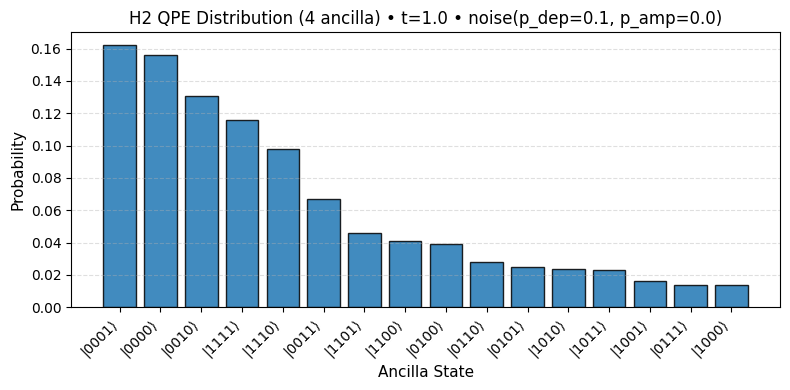

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/qpe/H2/distribution_dep10_ancilla4_t1.png


In [3]:
n_ancilla = 4
t_evol = 1.0
trotter_steps = 2
shots = 1000
noise_params = {"p_dep": 0.1, "p_amp": 0.0}

sig = signature_hash(
    molecule=molecule_name,
    n_ancilla=n_ancilla,
    t=t_evol,
    shots=shots,
    noise=noise_params,
    trotter_steps=trotter_steps,
)

result = load_qpe_result(molecule_name, sig)
if result is None:
    result = run_qpe(
        hamiltonian=H,
        hf_state=hf_state,
        n_ancilla=n_ancilla,
        t=t_evol,
        trotter_steps=trotter_steps,
        noise_params=noise_params,
        shots=shots,
        molecule_name=molecule_name,
    )
    save_qpe_result(result)

plot_qpe_distribution(result, show=True, save=True)


In [ ]:
# Sweep over depolarizing probability
p_dep_list = np.linspace(0.0, 0.1, 11)
seeds = list(range(3))

means, stds = [], []
peaks_mean, peaks_std = [], []

for p in p_dep_list:
    Es, Ps = [], []
    for seed in seeds:
        nparams = {"p_dep": float(p), "p_amp": 0.0, "seed": int(seed)}

        sig = signature_hash(
            molecule=molecule_name,
            n_ancilla=n_ancilla,
            t=t_evol,
            shots=shots,
            noise=nparams,
            trotter_steps=trotter_steps,
        )

        r = load_qpe_result(molecule_name, sig)
        if r is None:
            r = run_qpe(
                hamiltonian=H,
                hf_state=hf_state,
                n_ancilla=n_ancilla,
                t=t_evol,
                trotter_steps=trotter_steps,
                noise_params=nparams,
                shots=shots,
                molecule_name=molecule_name,
            )
            save_qpe_result(r)

        Es.append(r["energy"])
        Ps.append(r["probs"][r["best_bitstring"]])

    Es = np.array(Es)
    Ps = np.array(Ps)
    means.append(float(Es.mean()))
    stds.append(float(Es.std(ddof=1)))
    peaks_mean.append(float(Ps.mean()))
    peaks_std.append(float(Ps.std(ddof=1)))


💾 Saved QPE result → /workspaces/Variational_Quantum_Eigensolver/results/qpe/H2__QPE__cf7c0867e8c5.json
💾 Saved QPE result → /workspaces/Variational_Quantum_Eigensolver/results/qpe/H2__QPE__c6171eb54493.json


In [ ]:
plot_qpe_sweep(
    p_dep_list,
    means,
    stds,
    molecule=molecule_name,
    sweep_label="Depolarizing probability $p_{dep}$",
    ylabel="Energy (Ha)",
    title=f"Energy vs depolarizing ({len(seeds)} seeds)",
    ref_value=result["hf_energy"],
    ref_label="HF energy",
    ancilla=n_ancilla,
    noise_params={"p_dep": None, "p_amp": 0.0},
    show=True,
    save=True,
)


In [ ]:
plot_qpe_sweep(
    p_dep_list,
    peaks_mean,
    peaks_std,
    molecule=molecule_name,
    sweep_label="Depolarizing probability $p_{dep}$",
    ylabel="Peak probability",
    title=f"Peak sharpness vs depolarizing ({len(seeds)} seeds)",
    ref_value=None,
    ancilla=n_ancilla,
    noise_params={"p_dep": None, "p_amp": 0.0},
    show=True,
    save=True,
)
